In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
pd.set_option('display.float_format', '{:.2f}'.format)

In [111]:
dt = pd.read_csv("F:/Kaggle/E-commerce-Analysis/Pakistan Largest Ecommerce Dataset.csv")
dt.info()

c:\Users\LiangYu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,2,3,7,8,9,11,12,13,14,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   item_id                584524 non-null  float64
 1   status                 584509 non-null  object 
 2   created_at             584524 non-null  object 
 3   sku                    584504 non-null  object 
 4   price                  584524 non-null  float64
 5   qty_ordered            584524 non-null  float64
 6   grand_total            584524 non-null  float64
 7   increment_id           584524 non-null  object 
 8   category_name_1        584360 non-null  object 
 9   sales_commission_code  447349 non-null  object 
 10  discount_amount        584524 non-null  float64
 11  payment_method         584524 non-null  object 
 12  Working Date           584524 non-null  object 
 13  BI Status              584524 non-null  object 
 14   MV                    584524 non-

In [112]:
#保留需要的columns，並且刪除整行是空值的欄位
dt = dt.loc[:,["item_id", "status", "created_at", "sku", "price", "qty_ordered", "grand_total", "increment_id", "category_name_1","discount_amount", \
    "payment_method", "Year", "Month", "Customer ID"]]
dt = dt.dropna(how = 'all')

In [113]:
#另有11筆資料缺少會員id，也將這些訂單資料刪除。
#dt[dt["Customer ID"].isna()]
dt = dt.dropna(subset=["Customer ID"])

In [114]:
dt.describe()

,item_id,price,qty_ordered,grand_total,discount_amount,Year,Month,Customer ID
count,584513.00,584513.00,584513.00,584513.00,584513.00,584513.00,584513.00,584513.00
mean,565663.13,6348.82,1.30,8530.68,499.50,2017.04,7.17,45790.51
std,200120.93,14949.40,4.00,61321.38,1506.96,0.71,3.49,34414.96
min,211131.00,0.00,1.00,-1594.00,-599.50,2016.00,1.00,1.00
25%,394997.00,360.00,1.00,945.00,0.00,2017.00,4.00,13516.00
50%,568417.00,899.00,1.00,1960.40,0.00,2017.00,7.00,42856.00
75%,739102.00,4070.00,1.00,6999.00,160.52,2018.00,11.00,73536.00
max,905208.00,1012625.90,1000.00,17888000.00,90300.00,2018.00,12.00,115326.00


In [115]:
dt.describe(include=['object','bool'])

,status,created_at,sku,increment_id,category_name_1,payment_method
count,584498,584513,584493,584513,584349,584513
unique,16,789,84888,408776,16,18
top,complete,11/25/2016,MATSAM59DB75ADB2F80,100266667,Mobiles & Tablets,cod
freq,233685,15169,3775,72,115710,271955


In [138]:
#檢查 status 內不同的分類，接著把意思相近的分類整理成 "已完成"、"取消"、"處理中"
dt["status"].unique()

array(['completed', 'canceled', 'pending', '\\N', nan], dtype=object)

In [117]:
dt["status"] = dt["status"].replace(
    {"complete": "completed",
    "received": "completed",
    "cod": "completed",
    "paid": "completed",
    "closed": "completed",
    "exchange": "completed",
    "canceled": "canceled",
    "order_refunded": "canceled",
    "refund": "canceled",
    "fraud": "canceled",
    "payment_review": "pending",
    "pending": "pending",
    "processing": "pending",
    "holded": "pending",
    "pending_paypal": "pending"})

In [118]:
#將部分columns轉換成正確的資料類型
dt["Customer ID"] = dt["Customer ID"].astype(int)
dt["item_id"] = dt["item_id"].astype(str)
dt["qty_ordered"] = dt["qty_ordered"].astype(int)  
dt["Year"] = dt["Year"].astype(int)  
dt["Month"] = dt["Month"].astype(int)

In [119]:
#將消費日期轉為正確格式 %Y/%m/%m
dt["Day"] = dt["created_at"].str.split('/', expand=True)[1].apply(lambda x: x if len(x)>1 else "0"+x)
dt["Month"] = dt["Month"].astype(str).apply(lambda x: x if len(x)>1 else "0"+x)
dt["created_at"] = dt["Year"].astype(str) + "-" + dt["Month"] + "-" + dt["Day"].astype(str)
dt["created_at_date"] = pd.to_datetime(dt["created_at"])
print(dt["created_at_date"].min())
print(dt["created_at_date"].max())

2016-07-01 00:00:00
2018-08-28 00:00:00


In [120]:
#1 統計2016/07/01 - 2018/08/28 月營收
revenue = dt[dt["status"] == "completed"][["Year", "Month", "qty_ordered", "grand_total"]].groupby(["Year", "Month"]).agg("sum").sort_values(by=["Year", "Month"]).reset_index()
created_at_y_m = revenue["Year"].astype(str) + "-" + revenue["Month"]
revenue.insert(0,"Year_Month",created_at_y_m)
revenue

,Year_Month,Year,Month,qty_ordered,grand_total
0,2016-07,2016,07,6639,11720820.27
1,2016-08,2016,08,8506,17588479.23
2,2016-09,2016,09,9150,27503668.06
3,2016-10,2016,10,9074,24824142.90
4,2016-11,2016,11,42330,97895239.77
5,2016-12,2016,12,9125,26814176.77
6,2017-01,2017,01,9755,32184798.24
7,2017-02,2017,02,9422,30109818.33
8,2017-03,2017,03,13812,51529073.94
9,2017-04,2017,04,19237,44655625.57


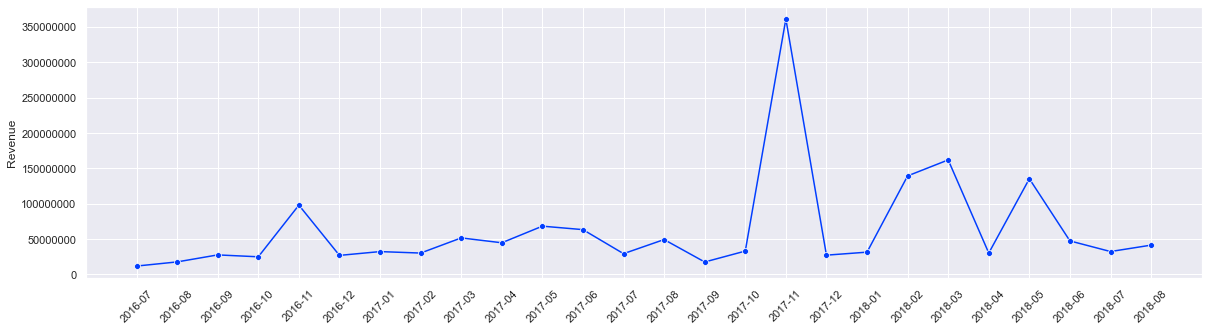

In [148]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid", palette="bright")
sns.lineplot(data=revenue, x="Year_Month", y="grand_total",marker="o")
ax.yaxis.get_major_formatter().set_scientific(False)
#ax.yaxis.get_major_formatter().set_useOffset(False)
ax.set_xlabel('')
ax.set_ylabel('Revenue')
plt.xticks(rotation=45);

In [122]:
created_at_y_m = dt["Year"].astype(str) + "-" + dt["Month"]
dt.insert(0,"Year_Month",created_at_y_m)

In [123]:
#2 統計每月份客單價 每月收入/訂單總數
orders = dt[dt["status"] == "completed"].groupby("Year_Month")["increment_id"].nunique().reset_index()
revenue["total_order"] = orders["increment_id"]
revenue["AOV"] = revenue["grand_total"]/revenue["total_order"]
revenue[["Year_Month","grand_total","total_order","AOV"]]


,Year_Month,grand_total,total_order,AOV
0,2016-07,11720820.27,4930,2377.45
1,2016-08,17588479.23,6467,2719.73
2,2016-09,27503668.06,7035,3909.55
3,2016-10,24824142.90,6304,3937.84
4,2016-11,97895239.77,30544,3205.06
5,2016-12,26814176.77,6686,4010.50
6,2017-01,32184798.24,5922,5434.79
7,2017-02,30109818.33,4946,6087.71
8,2017-03,51529073.94,7442,6924.09
9,2017-04,44655625.57,7072,6314.43


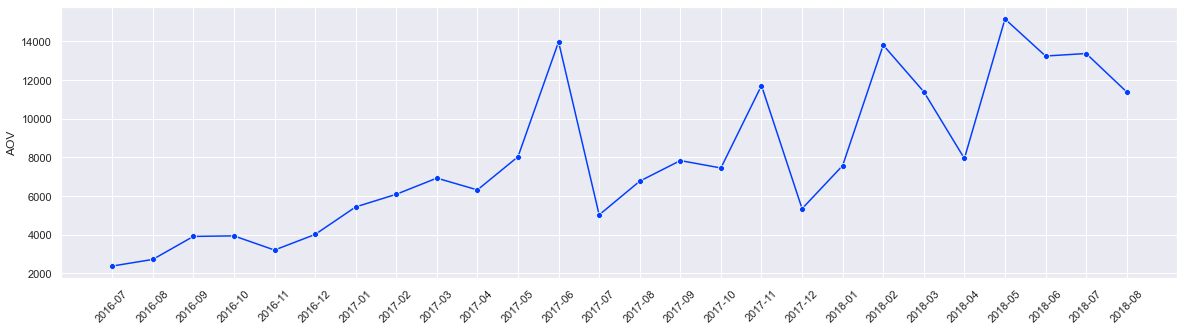

In [146]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid", palette="YlGn")
sns.lineplot(data=revenue, x="Year_Month", y="AOV",marker="o")
ax.set_xlabel("")
ax.set_ylabel("AOV")
plt.xticks(rotation=45);

In [125]:
#3 統計每月份人均消費訂單數
customer_id_count = dt[dt["status"] == "completed"].groupby(["Year_Month"])["Customer ID"].nunique().reset_index()
customer_id_count["month_total_order"] = orders["increment_id"]
customer_id_count["month_capita_order"] = round(customer_id_count["month_total_order"]/customer_id_count["Customer ID"],2)
customer_id_count

,Year_Month,Customer ID,month_total_order,month_capita_order
0,2016-07,1622,4930,3.04
1,2016-08,2640,6467,2.45
2,2016-09,3772,7035,1.87
3,2016-10,2765,6304,2.28
4,2016-11,12811,30544,2.38
5,2016-12,3642,6686,1.84
6,2017-01,3212,5922,1.84
7,2017-02,3327,4946,1.49
8,2017-03,4919,7442,1.51
9,2017-04,4119,7072,1.72


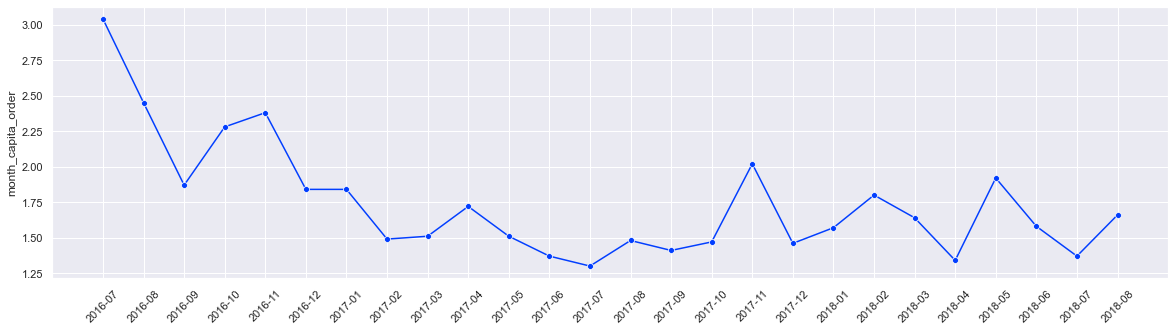

In [145]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid", palette="bright")
sns.lineplot(data=customer_id_count, x="Year_Month", y="month_capita_order",marker="o")
ax.set_xlabel("")
ax.set_ylabel("month_capita_order")
plt.xticks(rotation=45);

In [127]:
#4 計算每個月的回購率
purchase_time = dt.pivot_table(index="Customer ID",columns="Year_Month",values="increment_id",aggfunc="nunique",fill_value=0)
purchase_time

Year_Month,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
Customer ID,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14,31,28,46,105,26,15,26,30,15,...,14,2,1,3,0,0,0,0,0,7
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
115323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
115324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [128]:
pivot_purchase = purchase_time.applymap(lambda x:1 if x>0 else 0)
pivot_repurchase = (pivot_purchase.shift(-1,axis=1).fillna(0)+pivot_purchase).applymap(lambda x: 1 if x>1 else 0 )
pivot_repurchase = pivot_repurchase.shift(1,axis=1).fillna(0)
repurchase_rate = pivot_repurchase.sum()/pivot_purchase.sum()
repurchase_rate = repurchase_rate.reset_index(name = "repurchase_rate")

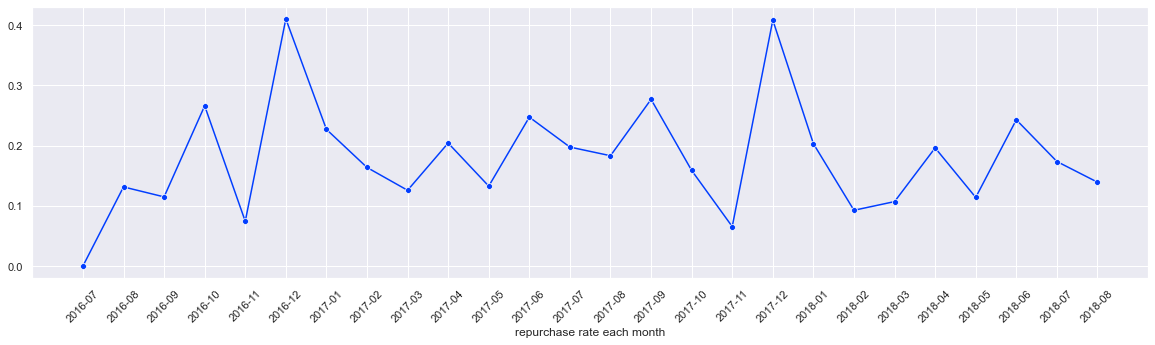

In [144]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid", palette="bright")
sns.lineplot(data=repurchase_rate, x="Year_Month", y="repurchase_rate",marker="o")
ax.set_xlabel("repurchase rate each month")
ax.set_ylabel("")
plt.xticks(rotation=45);

1.最近一次消費（Recency）。顧客上次消費時間愈近，價值愈大。
2.消費頻率（Frequency）。顧客在一個月或一年中，買了多少次東西？購買頻率愈高，用戶價值愈大。
3.消費金額（Monetary）。顧客一共在產品上花了多少錢？創造了多少利潤？消費金額愈高，用戶價值愈大。

In [205]:
#5 使用RFM模型將顧客分類成不同客群
#把 reference_date 設為顧客最後消費的3天後
reference_date = dt["created_at_date"].max() + timedelta(days=3)
print(f"Set the reference date as {reference_date}")

Set the reference date as 2018-08-31 00:00:00


In [206]:
rfm_dt = dt.groupby("Customer ID").agg \
    ({"created_at_date" : lambda created_at_date :(reference_date - created_at_date.max()).days,  # Recency
      "increment_id" : lambda increment_id: increment_id.nunique(),  # Frequency
      "grand_total":  lambda grand_total: grand_total.sum()}).reset_index().sort_values(by="Customer ID")    # Monetary

In [208]:
rfm_dt.head()

,Customer ID,created_at_date,increment_id,grand_total
0,1,791,1,1950.00
1,2,644,2,510.00
2,3,469,2,7430.00
3,4,4,387,2567596.45
4,5,791,1,1110.00


In [209]:
#把欄位重新命名為 Recency, Frequency, Monetary
rfm_dt.columns = ["Customer ID", "Recency", "Frequency", "Monetary"]
rfm_dt.head()

,Customer ID,Recency,Frequency,Monetary
0,1,791,1,1950.00
1,2,644,2,510.00
2,3,469,2,7430.00
3,4,4,387,2567596.45
4,5,791,1,1110.00


In [210]:
#R、F、M每一個維度劃分1~5分，5分代表最高分。
# Recency指標數字越小表示客戶近期剛購買，因此Recency越低則可得到更高分(5分)。
# Frequency和Monetary指標的表示客戶購買頻繁並且消費更多的金額，因此Frequency和Monetary值越高可得到更高分(5分)。
rfm_dt["Recency_Score"]  = pd.qcut(rfm_dt['Recency'], 5, [5, 4, 3, 2, 1])
rfm_dt["Frequency_Score"]  = pd.qcut(rfm_dt['Frequency'].rank(method="first"),  5, [1, 2, 3, 4, 5])
rfm_dt["Monetary_Score"]  = pd.qcut(rfm_dt['Monetary'], 5, [1, 2, 3, 4, 5])

In [212]:
rfm_dt["Recency_Score"] = rfm_dt["Recency_Score"].astype(int) 
rfm_dt["Frequency_Score"] = rfm_dt["Frequency_Score"].astype(int)
#rfm_dt.info()
rfm_dt_test = rfm_dt
rfm_dt_test["Segment_test"] = "n" 
rfm_dt_test

,Customer ID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Segment_test
0,1,791,1,1950.00,1,1,2,n
1,2,644,2,510.00,1,3,1,n
2,3,469,2,7430.00,2,3,3,n
3,4,4,387,2567596.45,5,5,5,n
4,5,791,1,1110.00,1,1,2,n
...,...,...,...,...,...,...,...,...
115321,115322,3,2,2596.00,5,4,2,n
115322,115323,3,1,44499.00,5,3,5,n
115323,115324,3,1,549.00,5,3,1,n
115324,115325,3,2,1199.00,5,4,2,n


In [213]:
#用loc去改
rfm_dt_test.loc[(rfm_dt_test["Recency_Score"] <= 2) & (rfm_dt_test["Frequency_Score"] <= 2),"Segment_test"] = "hibernating2"
rfm_dt_test

,Customer ID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Segment_test
0,1,791,1,1950.00,1,1,2,hibernating2
1,2,644,2,510.00,1,3,1,n
2,3,469,2,7430.00,2,3,3,n
3,4,4,387,2567596.45,5,5,5,n
4,5,791,1,1110.00,1,1,2,hibernating2
...,...,...,...,...,...,...,...,...
115321,115322,3,2,2596.00,5,4,2,n
115322,115323,3,1,44499.00,5,3,5,n
115323,115324,3,1,549.00,5,3,1,n
115324,115325,3,2,1199.00,5,4,2,n


In [207]:
rfm_dt["RFM_SCORE"] = (rfm_dt["Recency_Score"].astype(str) + rfm_dt["Frequency_Score"].astype(str) + rfm_dt["Monetary_Score"].astype(str))
rfm_dt.head()

KeyError: 'Recency_Score'

In [165]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

In [170]:
rfm_dt['Segment'] = rfm_dt['RFM_SCORE'].replace(seg_map, regex=True)

rfm_dt.head()

,index,Customer ID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_SCORE,Segment
0,0,1,791,1,1950.00,1,1,2,112,hibernating2
1,1,2,644,2,510.00,1,3,1,131,at_Risk1
2,2,3,469,2,7430.00,2,3,3,233,at_Risk3
3,3,4,4,387,2567596.45,5,5,5,555,champions5
4,4,5,791,1,1110.00,1,1,2,112,hibernating2


dt.loc[:,["item_id", "status", "created_at", "sku", "price", "qty_ordered", "grand_total", "increment_id", "category_name_1","discount_amount", \
    "payment_method", "Year", "Month", "Customer ID"]]Year_Month
    pivot_purchase = pivot_purchase_times.applymap(lambda x: 1 if x>0  else  0)
pivot_backpurchase  =(pivot_purchase.shift(-1,axis=1).fillna(0)+pivot_purchase).applymap(lambda x: 1 if x>1 else 0 )
pivot_backpurchase.sum()/pivot_purchase.sum()
/9946

In [132]:
# shop_sum = revenue.groupby("invoice_date_y")["price"].agg("sum")
# customer_id_count = df.groupby("invoice_date_y")["invoice_no","customer_id"].nunique()
# customer_id_count
# shop_per_num =pd.concat([shop_sum,customer_id_count],axis=1)
# shop_per_num

In [133]:
#order_data = pd.merge(df_orders, df_order_payments, on="order_id")
# order_count = order_data[order_data["order_status"] != "canceled"].groupby("order_purchase_y").agg("count")
# customer_id_count = order_data[order_data["order_status"] != "canceled"].groupby("order_purchase_y")["customer_id"].nunique()
# order_count


#4 每個月重複購買率
#5 每個月回購率v
#6 RFM模型

#7 商品銷量Top10
#8 商品退貨Top10
#9 付費方式占比
新舊客戶 >> 生成最早購買時間欄位?
https://medium.com/multiplyai/user-acquisition-stats-b3fd0928acff


In [134]:
#2016 - 2018 人均訂單數
# customer_id
# order_count = order_data[order_data["order_status"] != "canceled"].groupby("order_purchase_y").agg("count")
# customer_id_count = order_data[order_data["order_status"] != "canceled"].groupby("order_purchase_y")["customer_id"].nunique()
# order_count


In [135]:
# customer_id_count


# grand_total_check = dt[dt["grand_total"] < 0]["status"].value_counts().rename_axis("status").reset_index(name="counts")
# #grand_total_check
# fig, ax = plt.subplots(figsize=(15,5))
# sns.set(style="darkgrid", palette="bright")
# g = sns.barplot(data=grand_total_check, x="status", y="counts")
# ax.bar_label(g.containers[0], padding = 0, fontsize = 12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlabel('Order Status', fontsize=12, labelpad=10)
# plt.ylabel('Counts', fontsize=12, labelpad=10)